# Titanic's survival prediction

I will be trying in this notebook to predict the survival aboard the titanic using multiple machine learning algorithms. 


But before the prediction i will: 

- Clean the data from unusable features.

- Impute missing values with various approaches.

- Visualize the data to understand it more.

- Apply algorithms on a train test data sets splitted from the initial train data and compare their scores to see their efficiency.


Note that this is a work in progress and is to be improved with time.


Loading the modules

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn import neighbors, model_selection, preprocessing, svm, ensemble, linear_model
import os
os.chdir("/home/user/_python/data")
import statsmodels
from scipy import stats
import fancyimpute
import re

We load the training data:

In [2]:
train = pd.read_csv("titanic/train.csv")
test = pd.read_csv("titanic/test.csv")
train.head(7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


## Data treatment and engineering:

Let's check for missing values:

In [3]:
missing_train = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=["missing train"])
missing_test = pd.DataFrame(test.isnull().sum().sort_values(ascending=False), columns=["missing test"])

missing = pd.DataFrame(pd.concat([missing_train,missing_test], axis=1))
missing

,missing train,missing test
Age,177,86.0
Cabin,687,327.0
Embarked,2,0.0
Fare,0,1.0
Name,0,0.0
Parch,0,0.0
PassengerId,0,0.0
Pclass,0,0.0
Sex,0,0.0
SibSp,0,0.0


- Cabin has too many missing values, so it won't be valuable for the model.
- PassengerId and Ticket are apparently random so no use for them in the model.

So we better drop these three features.

In [4]:
train.drop(["Ticket", "Cabin", "PassengerId"], 1, inplace=True)
test.drop(["Ticket", "Cabin", "PassengerId"], 1, inplace=True)

Now we start the data treatment process; i will treat every feature on its own including filling missing values if existed, visualizing the feature and it's relationship with survival.

#### "Fare" :

Treat the missing value in the test data set:

There's only one missing value so i'll replace it with the mean.

In [5]:
test.Fare.fillna(np.mean(test.Fare), inplace=True)

[(-15, 285)]

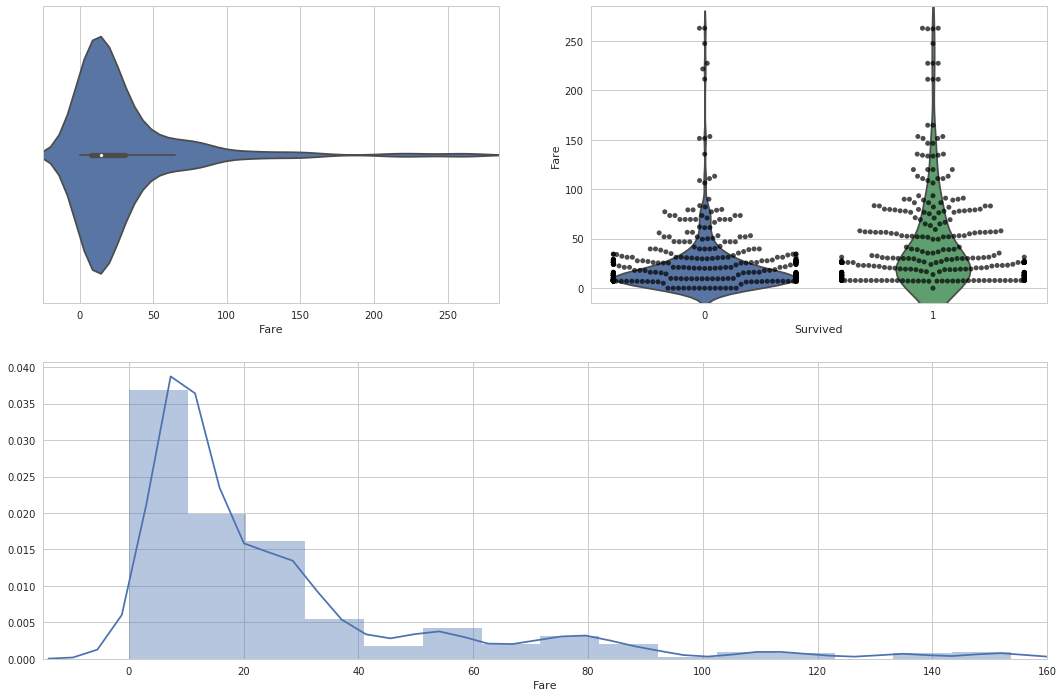

In [6]:
# Plotting

plt.figure(figsize=(18,12))

plt.subplot2grid((2,2),(0,0))

fare_viol = sns.violinplot(train.Fare)

fare_viol.set(xlim = (-25, 285))



plt.subplot2grid((2,2),(1,0), colspan=2)

fare_dist = sns.distplot(train.Fare)

fare_dist.set(xlim=(-15,160))



plt.subplot2grid((2,2),(0,1))

fare_viol2 = sns.violinplot(x = train.Survived, y = train.Fare, inner=None)

sns.swarmplot(x = train.Survived, y = train.Fare, color="k", alpha=0.7)

fare_viol2.set(ylim=(-15,285))

More the fare is important the more chance of survival.

#### Pclass :

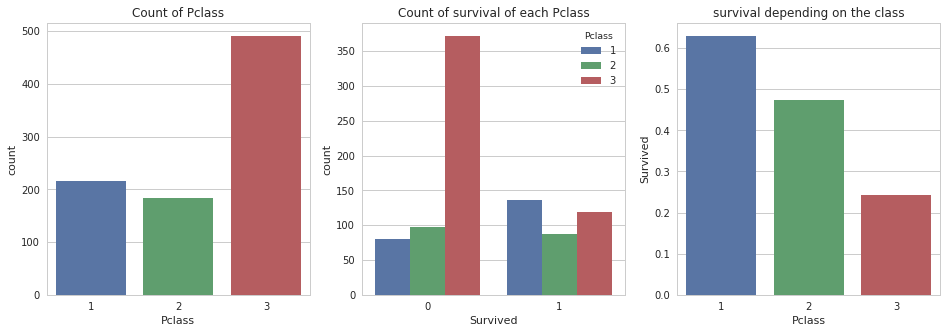

In [7]:
# Plotting

plt.figure(figsize=(16,5))

ax1 = plt.subplot2grid((1,3),(0,0))
sns.countplot(x=train.Pclass)
plt.title("Count of Pclass")

ax2 = plt.subplot2grid((1,3),(0,1))
sns.countplot(hue=train.Pclass,x=train.Survived)
plt.title("Count of survival of each Pclass")

ax3 = plt.subplot2grid((1,3),(0,2))
class_prc = train[["Survived", "Pclass"]].groupby(["Pclass"], as_index=False).mean()
sns.barplot(class_prc.Pclass, class_prc.Survived)
plt.title("survival depending on the class")

We notice that the class was important for survival, as we can see on the first plot at left that third class represents more than double of the first class, and yet more passengers from 1st class survived.

#### "SibSp" + "Parch" :

I will create a new feature named "Family", which is the combination of "SibSp" and "Parch", and will represent the number of family members on the titanic.

In [8]:
# Family for train:

train["Family"] = train["SibSp"] + train["Parch"]

train.drop(["SibSp", "Parch"], 1, inplace=True)


# Family for test:

test["Family"] = test["SibSp"] + test["Parch"]

test.drop(["SibSp", "Parch"], 1, inplace=True)

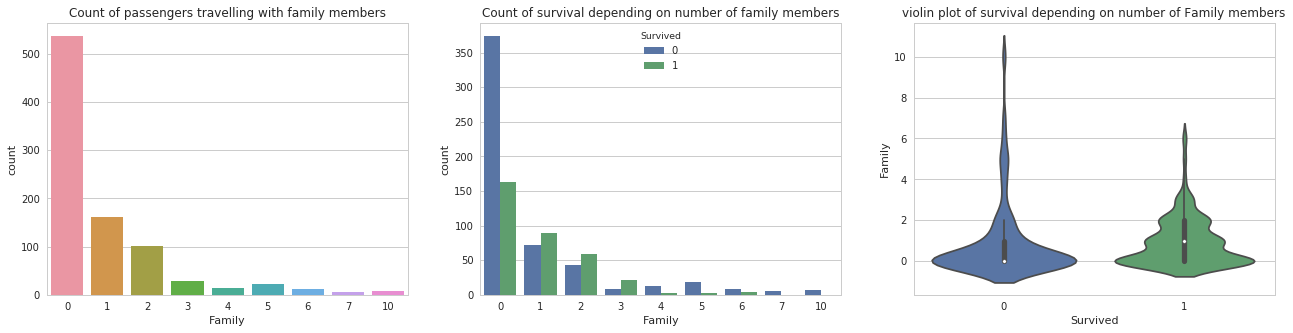

In [9]:
# Plotting:

plt.figure(figsize=(22,5))

plt.subplot2grid((1,3),(0,0))
sns.countplot(train.Family)
plt.title("Count of passengers travelling with family members")

plt.subplot2grid((1,3),(0,1))
sns.countplot(train.Family, hue=train.Survived)
plt.title("Count of survival depending on number of family members")

plt.subplot2grid((1,3),(0,2))
sns.violinplot(x=train.Survived, y=train.Family)
plt.title("violin plot of survival depending on number of Family members")

We can notice that passengers with at least one family member are more likely to survive than thos who have none. This is evident from the violin plot on the right, the violins are large at 0 family member, and shrink at one or more. Clearly the factore of number of family members is not to be neglected.

#### "Name" :

The Name feature on it's own has no effect on the survival, but we can extract the title out of the name, and that would be effective.

In [10]:
def get_titles(name):
    title_search = re.search("\w+, ([\w+\s]+)\. ", name)
    if title_search:
        return title_search.group(1)
    return ""                         
                             

train["Title"] = train['Name'].apply(get_titles)

test["Title"] = test["Name"].apply(get_titles)

In [11]:
print(pd.DataFrame(train.Title.value_counts()))
print(pd.DataFrame(test.Title.value_counts()))

              Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Mme               1
the Countess      1
Capt              1
Ms                1
Sir               1
Don               1
Lady              1
Jonkheer          1
        Title
Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dr          1
Ms          1
Dona        1


The title "Mme" means "Mrs" and "Mlle" means "Miss" in french

The title "Ms" means either "Mrs" or "Miss" but the name of the person with the "Ms" title has no husband's family name, so it's a "Miss"

I will also replace the titles with very few occurencies to either "Mr" or "Mrs", respecting the sex of the passenger, and if or not has a only a family husband's name.

Now i replace the titles by their meanings


In [12]:
# there's one female Dr (index = 796) so her title will be "Mrs"
train.loc[796, "Title"] = "Mrs"


train.Title.replace(["Mlle","Ms"], "Miss", inplace=True)

train.Title.replace(["Mme", "Lady", "the Countess"], "Mrs", inplace=True)

train.Title.replace("Dr", "Mr", inplace=True)

train.Title.replace(["Rev", "Major", "Col", "Capt", "Jonkheer", "Don", "Sir"], "Master", inplace=True)

test.Title.replace("Ms", "Miss", inplace=True)

test.Title.replace("Dr", "Mr", inplace=True)

test.Title.replace(["Rev", "Col"], "Master", inplace=True)

test.Title.replace("Dona", "Mrs", inplace=True)

Now i drop the "Name" feature:

In [13]:
train.drop(["Name"], 1, inplace=True)
test.drop(["Name"], 1, inplace=True)

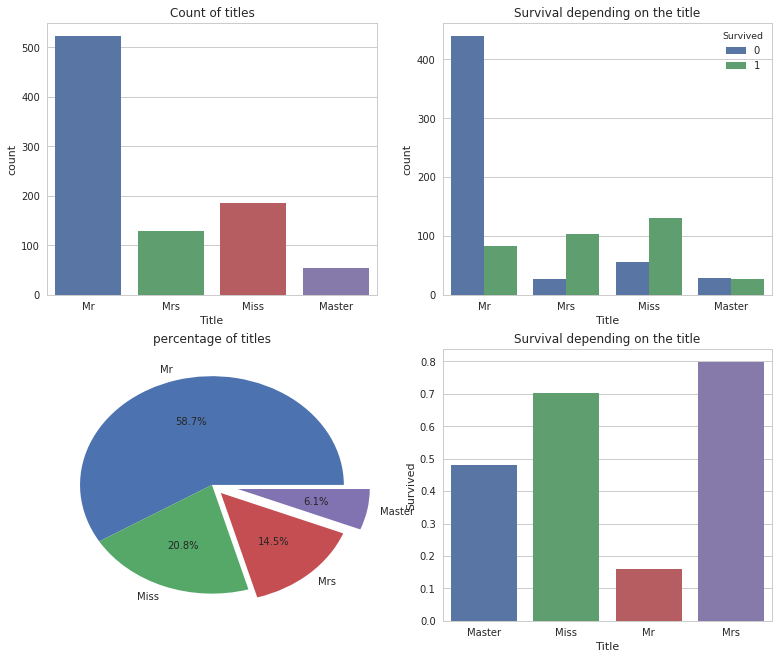

In [14]:
# Plotting

plt.figure(figsize=(13,11))

plt.subplot2grid((2,2),(0,0))

sns.countplot(train.Title)

plt.title("Count of titles")


plt.subplot2grid((2,2),(0,1))

sns.countplot(train.Title, hue=train.Survived)

plt.title("Survival depending on the title")


plt.subplot2grid((2,2),(1,0))

count_title = train.Title.value_counts()

labels_title = train.Title.value_counts().index

plt.pie(count_title, autopct = "%1.1f%%", labels=labels_title, explode=(0,0,0.1,0.2))

plt.title("percentage of titles")


plt.subplot2grid((2,2), (1,1))

title_prc = train[["Survived", "Title"]].groupby(["Title"], as_index=False).mean()

sns.barplot(title_prc.Title, title_prc.Survived)

plt.title("Survival depending on the title")

The title has a impact on survival as Mr has a very low chance of survival comparing to the other titles.

#### "Embarked" :

Treat the missing values in the train data set:

In [15]:
pd.DataFrame(train.Embarked.value_counts())

,Embarked
S,644
C,168
Q,77


It shows us that the vast majority of embarkments were from 'S'. With some confidence, we can fill in NaN values with 'S'.

In [16]:
train.Embarked.fillna(train.Embarked.mode()[0], inplace=True)

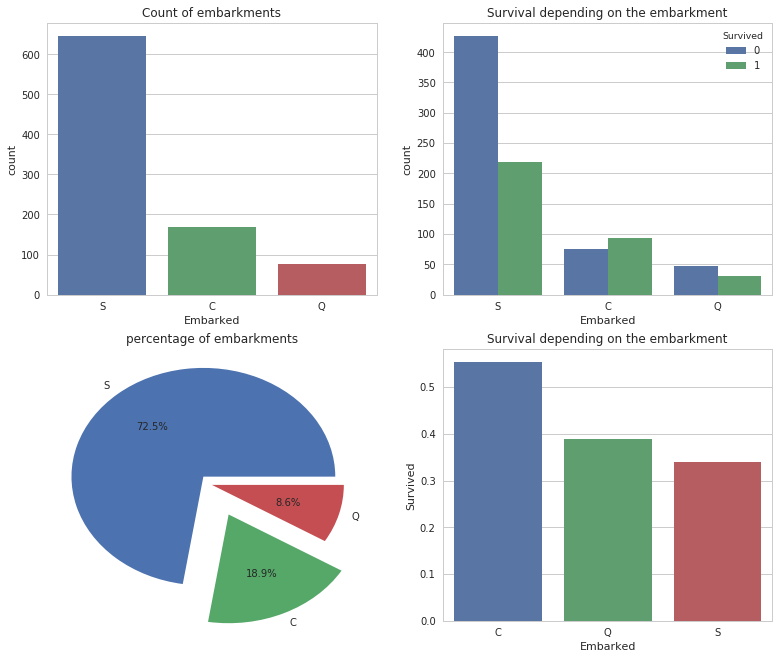

In [17]:
# Plotting:

plt.figure(figsize=(13,11))

plt.subplot2grid((2,2),(0,0))

sns.countplot(train.Embarked)

plt.title("Count of embarkments")


plt.subplot2grid((2,2),(0,1))

sns.countplot(train.Embarked, hue=train.Survived)

plt.title("Survival depending on the embarkment")


plt.subplot2grid((2,2),(1,0))

count_embarked = train.Embarked.value_counts()

labels_embarked = train.Embarked.value_counts().index

plt.pie(count_embarked, autopct = "%1.1f%%", labels=labels_embarked, explode=(0.1,0.3,0))

plt.title("percentage of embarkments")


plt.subplot2grid((2,2), (1,1))

embarked_prc = train[["Survived", "Embarked"]].groupby(["Embarked"], as_index=False).mean()

sns.barplot(embarked_prc.Embarked, embarked_prc.Survived)

plt.title("Survival depending on the embarkment")

We notice that passengers who embarked from Cherbourg have more chance to survive, i'd say either most of them was from first class or maybe most of them has high fare as high fare and first class passengers are likely to survive.

#### "Sex" :

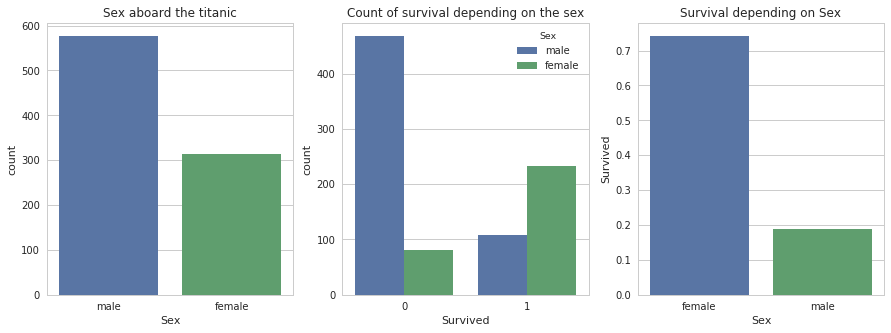

In [18]:
# Plotting:

plt.figure(figsize=(15,5))

plt.subplot2grid((1,3),(0,0))
sns.countplot(train.Sex)
plt.title("Sex aboard the titanic")

plt.subplot2grid((1,3),(0,1))
sns.countplot(hue=train.Sex, x=train.Survived)
plt.title("Count of survival depending on the sex")

plt.subplot2grid((1,3), (0,2))
sex_prc = train[["Survived","Sex"]].groupby(["Sex"], as_index=False).mean()
sns.barplot(sex_prc.Sex, sex_prc.Survived)
plt.title("Survival depending on Sex")

Impossible to miss the effect of the sex on survival, if you are a woman it's 75% chance of survival, not so lucky if you're a man.

#### "Age" : 

Lots of missing values imputation approches exist out there.

For the "Age" in both the train and the test data, using the KNN imputation is wise as the titanic data is small.

First i encode the categorical features into integers, to use them as preditors in the KNN missing values imputation on Age

In [19]:
# Dummies for the train data set:

train_dummy = pd.get_dummies(train)

# Dummies for test data

test_dummy = pd.get_dummies(test)

In [20]:
train_dummy.dtypes

Survived          int64
Pclass            int64
Age             float64
Fare            float64
Family            int64
Sex_female        uint8
Sex_male          uint8
Embarked_C        uint8
Embarked_Q        uint8
Embarked_S        uint8
Title_Master      uint8
Title_Miss        uint8
Title_Mr          uint8
Title_Mrs         uint8
dtype: object

Applying fancyimpute's KNN missing values imputation

In [21]:
# Imputing missing values on train data set:

train_imputed = pd.DataFrame(fancyimpute.KNN(k=3).complete(train_dummy), columns=list(train_dummy))

train_final = pd.concat([train_imputed.Age, train_dummy.drop(["Age"], 1)], axis=1)

print(pd.DataFrame(train_final.isnull().sum().sort_values(ascending=False), columns=["Train missing values"]))



# Imputing missing values on test data set:

test_imputed = pd.DataFrame(fancyimpute.KNN(k=3).complete(test_dummy), columns=list(test_dummy))

test_final = pd.concat([test_imputed.Age, test_dummy.drop(["Age"], 1)], axis=1)

print(pd.DataFrame(test_final.isnull().sum().sort_values(ascending=False), columns=["Test missing values"]))

Imputing row 1/891 with 0 missing, elapsed time: 0.264
Imputing row 101/891 with 0 missing, elapsed time: 0.267
Imputing row 201/891 with 0 missing, elapsed time: 0.270
Imputing row 301/891 with 1 missing, elapsed time: 0.272
Imputing row 401/891 with 0 missing, elapsed time: 0.274
Imputing row 501/891 with 0 missing, elapsed time: 0.275
Imputing row 601/891 with 0 missing, elapsed time: 0.278
Imputing row 701/891 with 0 missing, elapsed time: 0.280
Imputing row 801/891 with 0 missing, elapsed time: 0.281
              Train missing values
Title_Mrs                        0
Title_Mr                         0
Title_Miss                       0
Title_Master                     0
Embarked_S                       0
Embarked_Q                       0
Embarked_C                       0
Sex_male                         0
Sex_female                       0
Family                           0
Fare                             0
Pclass                           0
Survived                         0

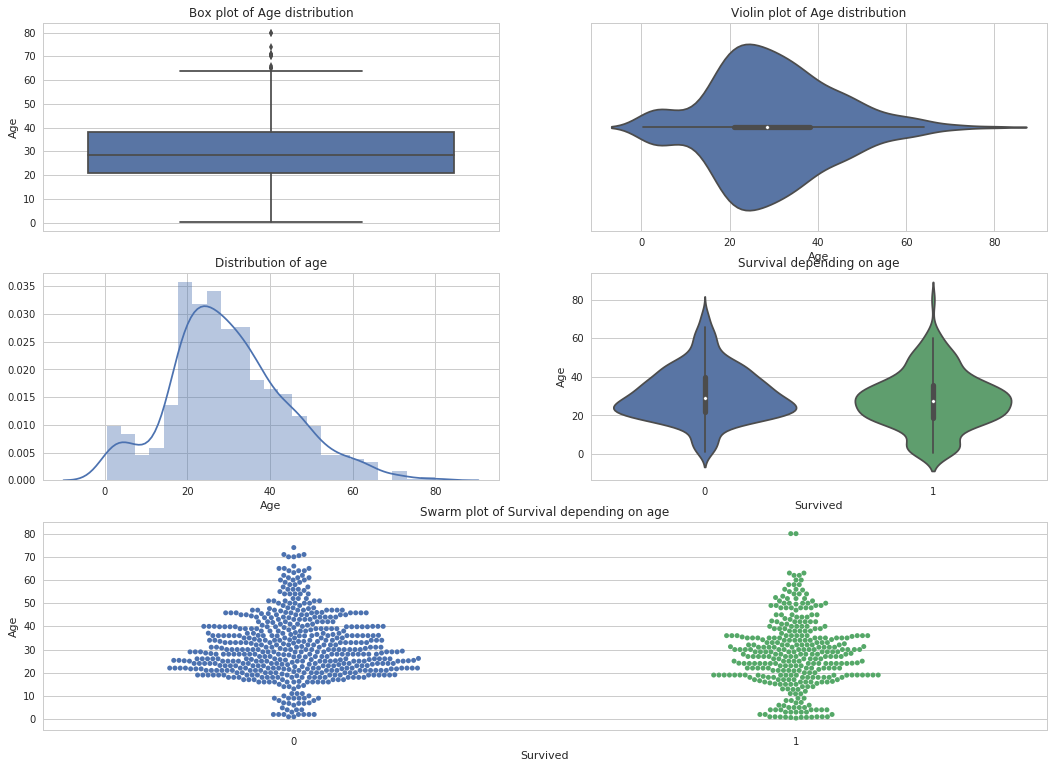

In [22]:
# Plotting:

plt.figure(figsize=(18,13))


plt.subplot2grid((3,2),(0,0))
sns.boxplot(train_final.Age, orient="v")
plt.title("Box plot of Age distribution")

plt.subplot2grid((3,2),(0,1))
sns.violinplot(train_final.Age)
plt.title("Violin plot of Age distribution")

plt.subplot2grid((3,2),(1,0))
sns.distplot(train_final.Age)
plt.title("Distribution of age")

plt.subplot2grid((3,2),(1,1))
sns.violinplot(x=train_final.Survived, y=train_final.Age, split=True)
plt.title("Survival depending on age")

plt.subplot2grid((3,2),(2,0), colspan=2)
sns.swarmplot(y=train_final.Age, x=train_final.Survived,)
plt.title("Swarm plot of Survival depending on age")

Apparently age is not extremely effective on survival.

In [23]:
train_final.head(7)

,Age,Survived,Pclass,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,22.000000,0,3,7.2500,1,0,1,0,0,1,0,0,1,0
1,38.000000,1,1,71.2833,1,1,0,1,0,0,0,0,0,1
2,26.000000,1,3,7.9250,0,1,0,0,0,1,0,1,0,0
3,35.000000,1,1,53.1000,1,1,0,0,0,1,0,0,0,1
4,35.000000,0,3,8.0500,0,0,1,0,0,1,0,0,1,0
5,45.833334,0,3,8.4583,0,0,1,0,1,0,0,0,1,0
6,54.000000,0,1,51.8625,0,0,1,0,0,1,0,0,1,0


In [24]:
test_final.head()

,Age,Pclass,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,34.5,3,7.8292,0,0,1,0,1,0,0,0,1,0
1,47.0,3,7.0000,1,1,0,0,0,1,0,0,0,1
2,62.0,2,9.6875,0,0,1,0,1,0,0,0,1,0
3,27.0,3,8.6625,0,0,1,0,0,1,0,0,1,0
4,22.0,3,12.2875,2,1,0,0,0,1,0,0,0,1


## Modeling :

First i draw a heatmap of the correlation between features to spot colinearity:

Axes(0.125,0.125;0.62x0.755)


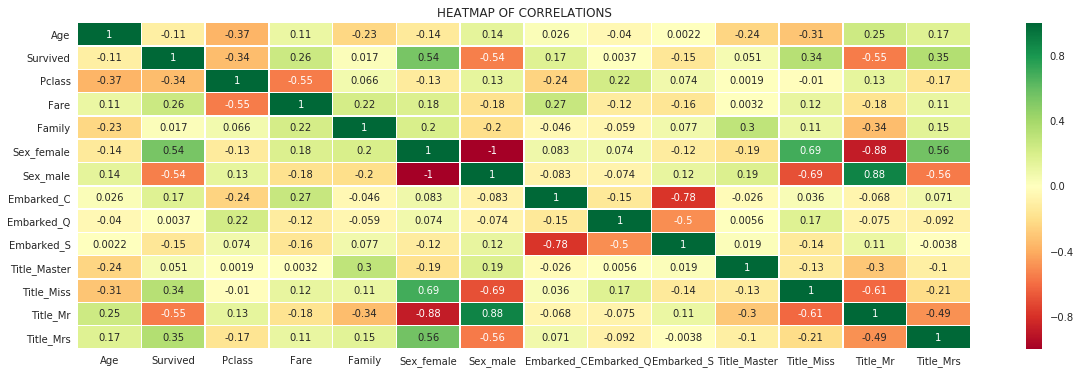

In [25]:
plt.figure(figsize=(20,6))

print(sns.heatmap(train_final.corr(), annot=True, linewidths=0.5, cmap='RdYlGn'))

plt.title("HEATMAP OF CORRELATIONS")

On the correlation heatmap we notice that "Title_Mr", "Embarked_S" and "Sex_Male" have correlations with other features that can effect negatively the model, i will drop them.

In [26]:
train_model = train_final.copy()

train_model = train_model.drop(["Sex_male", "Embarked_S", "Title_Mr"], 1)

test_model = test_final.drop(["Sex_male", "Embarked_S", "Title_Mr"], 1)

I split the train data into train and test data sets to test the efficiency of the models, then train the models with multiple algorithms:

In [91]:
x = train_model.drop(["Survived"], axis=1)
y = train_model["Survived"]
x_train, x_test, y_train, y_test = model_selection.train_test_split( x, y , test_size=0.2)




clf_knn = neighbors.KNeighborsClassifier()

clf_knn.fit(x_train, y_train)

score_knn = clf_knn.score(x_test, y_test)



clf_svc = svm.SVC()

clf_svc.fit(x_train, y_train)

score_svc = clf_svc.score(x_test, y_test)



clf_lgr = linear_model.LogisticRegression()

clf_lgr.fit(x_train, y_train)

score_lgr = clf_lgr.score(x_test, y_test)



clf_rdmfrst = ensemble.RandomForestClassifier()

clf_rdmfrst.fit(x_train, y_train)

score_rdmfrst = clf_rdmfrst.score(x_test, y_test)



clf_sgd = linear_model.SGDClassifier()

clf_sgd.fit(x_train, y_train)

score_sgd = clf_sgd.score(x_test, y_test)





scores = [score_knn, score_lgr, score_rdmfrst, score_sgd, score_svc]

clf_names = ["K nearest neighbors", "Logistic regression", "Random forrest", "Stochastic gradient descent", 
             "Support vector classifier"]

clf_scores = pd.DataFrame({"Algorithms": clf_names, "Scores": scores} )

clf_scores.sort_values(by=["Scores"], ascending=False, inplace=True)

clf_scores

/home/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


,Algorithms,Scores
1,Logistic regression,0.871508
2,Random forrest,0.810056
0,K nearest neighbors,0.743017
4,Support vector classifier,0.726257
3,Stochastic gradient descent,0.698324
